### Image Classification with CNN

In [1]:
# libraries imported
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gzip
import numpy as np
from torch.utils.data import DataLoader, Dataset

### Download the dataset within folder

In [2]:
import os
import requests

# Create directories if they don't exist
os.makedirs('./data/fashion-mnist', exist_ok=True)

# URLs for Fashion MNIST files
base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
files = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz"
]

# Download files
for file_name in files:
    file_path = f"./data/fashion-mnist/{file_name}"
    if not os.path.exists(file_path):
        print(f"Downloading {file_name}...")
        response = requests.get(base_url + file_name)
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"Saved {file_name} to {file_path}")
    else:
        print(f"{file_name} already exists. Skipping download.")


train-images-idx3-ubyte.gz already exists. Skipping download.
train-labels-idx1-ubyte.gz already exists. Skipping download.
t10k-images-idx3-ubyte.gz already exists. Skipping download.
t10k-labels-idx1-ubyte.gz already exists. Skipping download.


### Helper functions

In [3]:
# Function to load Fashion MNIST dataset
def load_mnist_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
        return data / 255.0  # Normalize to [0, 1]

def load_mnist_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
        return labels
    
def transform(image):
    # Normalize image to range [-1, 1] and convert to tensor
    image = (image - 0.5) / 0.5
    return torch.tensor(image, dtype=torch.float32).unsqueeze(0)

# Custom Dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

### Loading and preprocessing of the data

In [4]:
# File paths for Fashion MNIST
train_images_path = "./data/fashion-mnist/train-images-idx3-ubyte.gz"
train_labels_path = "./data/fashion-mnist/train-labels-idx1-ubyte.gz"
test_images_path = "./data/fashion-mnist/t10k-images-idx3-ubyte.gz"
test_labels_path = "./data/fashion-mnist/t10k-labels-idx1-ubyte.gz"
# Load the data
train_images = load_mnist_images(train_images_path)
train_labels = load_mnist_labels(train_labels_path)
test_images = load_mnist_images(test_images_path)
test_labels = load_mnist_labels(test_labels_path)

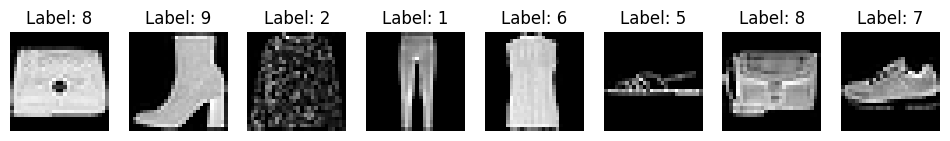

In [5]:
def transform(image):
    # Normalize image to range [-1, 1] and convert to tensor
    image = (image - 0.5) / 0.5
    return torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

# Create datasets
train_dataset = FashionMNISTDataset(train_images, train_labels, transform=transform)
test_dataset = FashionMNISTDataset(test_images, test_labels, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: Display a batch of images
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot some images
fig, axes = plt.subplots(1, 8, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze().numpy(), cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.show()

### CNN Architecture

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()

### Selecting Loss Function and Optimizer

In [7]:
criterion = nn.CrossEntropyLoss()

# manual adam optimizer
def manual_adam_optimizer(model, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, max_epochs=10):
    m = {param: torch.zeros_like(param) for param in model.parameters()}
    v = {param: torch.zeros_like(param) for param in model.parameters()}
    
    itr = 0
    
    for epoch in range(max_epochs):
        for inputs, targets in train_loader:
            model.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            itr += 1
            with torch.no_grad():
                for param in model.parameters():
                    if param.grad is not None:
                        grad = param.grad

                        m[param] = beta1 * m[param] + (1 - beta1) * grad

                        v[param] = beta2 * v[param] + (1 - beta2) * grad ** 2

                        m_hat = m[param] / (1 - beta1 ** itr)
                        v_hat = v[param] / (1 - beta2 ** itr)

                        param -= learning_rate * m_hat / (torch.sqrt(v_hat) + epsilon)

        print(f"Epoch [{epoch+1}/{max_epochs}], Loss: {loss.item()}")

manual_adam_optimizer(model)


Epoch [1/10], Loss: 0.292066365480423
Epoch [2/10], Loss: 0.11838395893573761
Epoch [3/10], Loss: 0.2154434770345688
Epoch [4/10], Loss: 0.19568946957588196
Epoch [5/10], Loss: 0.1859331578016281
Epoch [6/10], Loss: 0.13849125802516937
Epoch [7/10], Loss: 0.11737122386693954
Epoch [8/10], Loss: 0.021808214485645294
Epoch [9/10], Loss: 0.06763505190610886
Epoch [10/10], Loss: 0.05945281684398651


### Evaluating the model

In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 91.61%


### Visualizing predictions

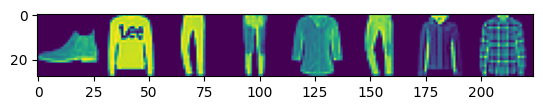

Predicted:  9 2 1 1 6 1 4 6


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Manually create a grid of images
def create_image_grid(images, num_images=8):
    # Reshape the image tensor to have a grid structure
    grid = torch.cat([images[i] for i in range(num_images)], dim=2)
    return grid

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Assuming you want to display the first 8 images
grid_image = create_image_grid(images, num_images=8)

# Display the images
imshow(grid_image)
# Print predicted labels for the first 8 images
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print("Predicted: ", " ".join(f"{predicted[j]}" for j in range(8)))